# PCA vs. LDA Assignment
### Michelle Hackl
#### CS156 - Prof. Sterne

In [1]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

from glob import glob
from PIL import Image
from resizeimage import resizeimage

from sklearn.model_selection import train_test_split as ttsplit, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Image processing steps
We start by importing the images and resizing them into arrays of 600 (200 pixels á 3 colors). 
Optional preprocessing steps:
1. Checking for duplicate images across the data sets (fastest by using a hash).
2. Removing images that have a dark background by checking for the colors of the edge pixels. This avoids all images that are up-close or with distracting backgrounds.
3. Manually correcting image labels. I noticed several shirts labeled as jerseys and vice versa at a quick glance.

In [3]:
jerseydir = glob("/Users/michellehackl/Google_Drive/School/Minerva/Classes/2018:2019/CS156/PCA/Jersey/*")
shirtdir = glob("/Users/michellehackl/Google_Drive/School/Minerva/Classes/2018:2019/CS156/PCA/Shirt/*")

In [4]:
#opening and resizing the images into flat arrays of 600
jerseys = []
for path in jerseydir:
    with open(path, 'r+b') as f:
        with Image.open(f) as i:
            cover = resizeimage.resize_cover(i, [20, 10])
            if len(np.array(cover).flatten()) == 600: 
                jerseys.append((np.array(cover).flatten(), 0))
                i.close() #to ensure memory doesn't overflow
            
shirts = []
for path in shirtdir:
    with open(path, 'r+b') as f:
        with Image.open(f) as i:
            cover = resizeimage.resize_cover(i, [20, 10])
            if len(np.array(cover).flatten()) == 600: 
                shirts.append((np.array(cover).flatten(), 1))
                i.close()

In [5]:
jerseys = np.asarray(jerseys)
shirts = np.asarray(shirts)

images = np.append(jerseys[:,0], shirts[:,0])
labels = np.append(jerseys[:,1], shirts[:,1])

#unstacking the arrays in array
images = np.stack(i for i in images)
labels = np.stack(i for i in labels)

#conversion for LDA later
X = images.astype('float64')
y = labels.astype('float64')

## Linear Classifier
I use a simple Logistic Regression Classifier as the baseline model. GridSearchCV helps to find the optimal parameters for the model, as well as perform cross-validation on them. Ideal parameters are then used to train the model and evaluate it on the hold-out testing data.

In [6]:
random.seed(1337)
X_train, X_test, y_train, y_test = ttsplit(X, y, test_size=0.3)

LR = LR()
parameters = [{'C': [1.0, 0.1, 0.01], 'max_iter': [500],
                'solver': ['sag', 'saga', 'lbfgs']}]

grid = GridSearchCV(LR, cv=5, param_grid=parameters,
                    scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1.0, 0.1, 0.01], 'max_iter': [500], 'solver': ['sag', 'saga', 'lbfgs']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [7]:
print "Parameters used for LR:"
print grid.best_params_
optimal_LR = grid.best_estimator_

y_pred = optimal_LR.predict(X_test)
acc_train = grid.best_score_
acc_test = accuracy_score(y_test, y_pred)
print "LR accuracy training data: ", acc_train
print "LR accuracy testing data: ", acc_test

Parameters used for LR:
{'C': 1.0, 'max_iter': 500, 'solver': 'sag'}
LR accuracy training data:  0.567484662577
LR accuracy testing data:  0.567342073897


## PCA
We fit our PCA on training data and then use the trained PCA model to transform the testing data separately, as to not have information from the training data bleed into the test set transformation. Not having this separation might mean, that the components PCA picks are already tailored to improve performance on the testing data.

Using the explained variance ratio, I have decided to settle for 9 components, which explain 75% of my data's variance. This seems to be the "elbow", indicating the ideal variance/dimensionality tradeoff point.

Additionally, I train a PCA model with 1D data, for visualization purposes and comparison against the LDA later. Note that this model works poorly, as was to be expected, since a single component only explains about 30% of our variance.

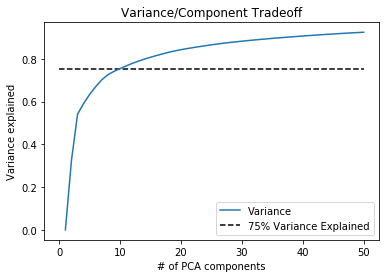

In [8]:
variance_exp = []
for i in range(50):
    pca = PCA(n_components=i)
    _ = pca.fit(X_train)
    variance_exp.append(sum(pca.explained_variance_ratio_))
    
plt.plot(range(1,51), variance_exp, label="Variance")
plt.hlines(0.75,0,50, linestyles='dashed', label="75% Variance Explained")

plt.xlabel("# of PCA components")
plt.ylabel("Variance explained")
plt.title("Variance/Component Tradeoff")
plt.legend(loc=4)

plt.show()

In [9]:
optimal_pca = PCA(n_components=9) 
X_test_pca = optimal_pca.fit_transform(X_test)
X_train_pca = optimal_pca.transform(X_train)

In [10]:
optimal_LR.fit(X_train_pca, y_train)
y_pred_pca = optimal_LR.predict(X_test_pca)

In [11]:
acc_train_pca = optimal_LR.score(X_train_pca, y_train)
acc_test_pca = accuracy_score(y_test, y_pred_pca)
print "LR accuracy training data with PCA: ", acc_train_pca
print "LR accuracy testing data with PCA: ", acc_test_pca

LR accuracy training data with PCA:  0.624744376278
LR accuracy testing data with PCA:  0.610250297974


In [12]:
pca_1d = PCA(n_components=1) 
X_test_pca_1d = pca_1d.fit_transform(X_test)
X_train_pca_1d = pca_1d.transform(X_train)

optimal_LR.fit(X_train_pca_1d, y_train)
y_pred_pca_1d = optimal_LR.predict(X_test_pca_1d)

acc_train_pca_1d = optimal_LR.score(X_train_pca_1d, y_train)
acc_test_pca_1d = accuracy_score(y_test, y_pred_pca_1d)
print "LR accuracy training data with PCA (1d): ", acc_train_pca_1d
print "LR accuracy testing data with PCA (1d): ", acc_test_pca_1d

LR accuracy training data with PCA (1d):  0.558282208589
LR accuracy testing data with PCA (1d):  0.536352800954


## LDA
With LDA, we are performing supervised dimensionality reduction (as opposed to PCA's unsupervised, variance-based approach). 

In [13]:
lda = LDA()
parameters_lda = [{'shrinkage': ['auto', None],
                   'solver': ['eigen']}]

grid_lda = GridSearchCV(lda, cv=5, param_grid=parameters_lda,
                        scoring='accuracy')
grid_lda.fit(X_train, y_train)

print "Parameters used for LR:"
print grid_lda.best_params_
optimal_lda = grid_lda.best_estimator_

Parameters used for LR:
{'shrinkage': None, 'solver': 'eigen'}


In [14]:
X_train_lda = optimal_lda.fit_transform(X_train, y_train)
X_test_lda = optimal_lda.transform(X_test)

In [15]:
optimal_LR.fit(X_train_lda, y_train)
y_pred_lda = optimal_LR.predict(X_test_lda)

acc_train_lda = optimal_LR.score(X_train_lda, y_train)
acc_test_lda = accuracy_score(y_test, y_pred_lda)
print "LR accuracy training data with LDA: ", acc_train_lda
print "LR accuracy testing data with LDA: ", acc_test_lda

LR accuracy training data with LDA:  0.775051124744
LR accuracy testing data with LDA:  0.568533969011


## Comparing LDA to PCA
Here I compare the dimensionality reduction of LDA to that of PCA (using n_components = 1). As we would expect, LDA is able to distinguish between the two data sets with slightly higher accuracy (note that we can see a small difference between the datasets in the second plot), but because of the general similarity of shirts and jerseys in our set, both do a rather terrible job at creating a clear separation.

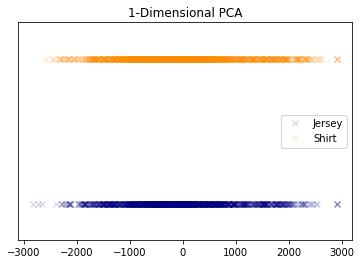

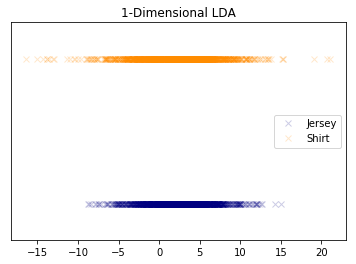

In [20]:
plt.figure()
colors = ['navy', 'darkorange']
target_names = ['Jersey', 'Shirt']

X_pca = np.concatenate((X_train_pca_1d, X_test_pca_1d), axis=0)
X_lda = np.concatenate((X_train_lda, X_test_lda), axis=0)

for color, i, name in zip(colors, [0, 1], target_names):
    plt.plot(X_pca[y == i, 0], len(X_pca[y==i,0]) * [0.1*i], 'x',
                color=color, alpha=0.2, lw=1, label=name)
plt.legend(loc=7, shadow=False, scatterpoints=1)
plt.ylim((-0.025,0.125))
plt.yticks([])
plt.title('1-Dimensional PCA')
plt.figure()

for color, i, name in zip(colors, [0, 1], target_names):
    plt.plot(X_lda[y == i, 0], len(X_lda[y==i,0]) * [0.1*i], 'x',
                color=color, alpha=0.2, lw=1, label=name)
plt.legend(loc=7, shadow=False, scatterpoints=1)
plt.ylim((-0.025,0.125))
plt.yticks([])
plt.title('1-Dimensional LDA')

plt.show()

In [17]:
results = {
    'Logistic Regression':[acc_train, acc_test],
    'PCA 9 components':[acc_train_pca, acc_test_pca],
    'PCA 1 component':[acc_train_pca_1d, acc_test_pca_1d],
    'LDA 1 component':[acc_train_lda, acc_test_lda]
}
pd.DataFrame(results, index=['Training Accuracy', 'Testing Accuracy']).round(2)

,LDA 1 component,Logistic Regression,PCA 1 component,PCA 9 components
Training Accuracy,0.78,0.57,0.56,0.62
Testing Accuracy,0.57,0.57,0.54,0.61


## Conclusions
From the above table, we can see that while LDA manages to most clearly distinguish Jerseys from Shirts in the training data, it performs no better than our standard LogReg model on the test data. PCA with the same amount of dimensions as LDA ranks dead last at what is essentially chance level and PCA with optimized number of components performs best on the unseen testing data, though also only marginally above chance level.

With better data pre-processing, I would expect to see a slight improvement in performance, but the images are often barely classifiable to myself (human observer) and the amount to which the images were incorrectly labeled might also have had an impact on classifier performance.

And what's the real difference between a jersey and a shirt anyways...?